## Pathway and Drug Enrichment of FdS and MCNM from MultiNicheNet

This notebook contains code to perform Pathway and drug enrichment analyses on the FdS genes and the subnetwork MCNMs from multinichenet outputs.

 - FdS Signature
 - Target gene list of FAP_Ligands in FAP_Polyp
 - Target gene list of FAP_Ligands in FAP_Unaffected
 - Target gene list of FAP_Ligands in sporadic_CRC

In [1]:
import pandas as pd
import gseapy as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def multi_enrichr_analysis(gene_list, gene_sets=None, organism='Human', cutoff=0.05):
    """
    Run Enrichr analysis on a list of genes across multiple gene sets and return combined results.

    Parameters:
        gene_list (list): List of gene symbols (e.g., ['TP53', 'EGFR']).
        gene_sets (list): List of Enrichr gene set names to query.
        organism (str): Organism, default is 'Human'.
        cutoff (float): Adjusted p-value threshold for filtering.

    Returns:
        pd.DataFrame: Combined enrichment results.
    """

    if gene_sets is None:
        gene_sets = [
            'MSigDB_Hallmark_2020',
            'DGIdb_Drug_Targets_2024',
            'KEGG_2021_Human'
        ]
    
    combined_results = []

    for gs in gene_sets:
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gs,
                organism=organism,
                outdir=None,  # Prevent file output
            )
            df = enr.results
            if not df.empty:
                df['Gene_set'] = gs
                df = df[df['Adjusted P-value'] < cutoff]
                combined_results.append(df)
        except Exception as e:
            print(f"Failed on {gs}: {e}")

    if combined_results:
        return pd.concat(combined_results, ignore_index=True)
    else:
        print("No significant enrichments found.")
        return pd.DataFrame()

In [3]:
drug_gene_sets = [
    'DGIdb_Drug_Targets_2024'
]

pathway_gene_sets = [
    'MSigDB_Hallmark_2020'
    ]

In [4]:
def preprocess_enrichr(df, label, p_thresh=0.05, top_n=20):
    df = df[df['Adjusted P-value'] < p_thresh].copy()
    df['-log10_pval'] = -np.log10(df['Adjusted P-value'])
    df = df[['Term', '-log10_pval','Genes']].sort_values(by='-log10_pval', ascending=False) 
    df['-log10_pval'] = df['-log10_pval'].fillna(0)
    df['Dataset'] = label
    return df

In [6]:
FAP_ligands = ['LAMB1', 'LAMC2', 'TGFBI', 'SEMA4D', 'AGRN', 'SEMA5A','SEMA3F' ,'INHBA', 'LAMA5', 'COL7A1']

FAP_targets = ['SOX9' ,'CCND1' ,'MET', 'ID1' , 'PTMA',  'CLU' , 'TGIF1', 'EDN1' , 'GDF15']

In [ ]:
# FAP_unaffected mulitnichenet data
FAP_unaffected = pd.read_csv('C:/Users/jondor/Documents/DT/FAP/lr_target_df_2.csv')
FAP_unaffected = FAP_unaffected[FAP_unaffected['group']== 'FAP_Unaffected']
#FAP_unaffected = FAP_unaffected[FAP_unaffected['sender'].isin(['Epithelial']) & FAP_unaffected['receiver'].isin(['Epithelial'])]
FAP_unaffected = FAP_unaffected[FAP_unaffected['ligand'].isin(FAP_ligands)]

In [ ]:
## FAP Polyps multinichenet data 
FAP_polyps = pd.read_csv('C:/Users/jondor/Documents/DT/FAP/lr_target_df_2.csv')
FAP_polyps = FAP_polyps[FAP_polyps['group']== 'FAP_Polyp']
#FAP_polyps = FAP_polyps[FAP_polyps['sender'].isin(['Epithelial']) & FAP_polyps['receiver'].isin(['Epithelial'])]
FAP_polyps = FAP_polyps[FAP_polyps['ligand'].isin(FAP_ligands)]

In [ ]:
pd.DataFrame(FAP_polyps['target'].unique(), columns=['target']) \
  .to_excel('C:/Users/jondor/Documents/DT/FAP/FAP_polyps_targets_only.xlsx', index=False)

In [7]:
### sporadic CRC multinichenet data
sporadic_CRC = pd.read_csv('C:/Users/jondor/Documents/DT/Sporadic_CRC/lr_target_df_1.csv')
#sporadic_CRC = sporadic_CRC[sporadic_CRC['sender'].isin(['Epithelial']) & sporadic_CRC['receiver'].isin(['Epithelial'])]
sporadic_CRC = sporadic_CRC[sporadic_CRC['ligand'].isin(FAP_ligands)]

In [8]:
FAP_ligands + FAP_targets

['LAMB1',
 'LAMC2',
 'TGFBI',
 'SEMA4D',
 'AGRN',
 'SEMA5A',
 'SEMA3F',
 'INHBA',
 'LAMA5',
 'COL7A1',
 'SOX9',
 'CCND1',
 'MET',
 'ID1',
 'PTMA',
 'CLU',
 'TGIF1',
 'EDN1',
 'GDF15']

FdS

In [ ]:
## Fds signature - Pathway enrichment
res = multi_enrichr_analysis(FAP_targets + FAP_ligands, gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
summary_genes = summary_genes.sort_values(by='Adjusted P-value')
summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FdS_Signature_Pathway_results.xlsx', index=False)
summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FdS_Signature_Pathway_results.parquet', index=False)

In [ ]:
## FdS signature - Drug Enrichment
res = multi_enrichr_analysis(FAP_targets + FAP_ligands, gene_sets=drug_gene_sets, organism='Human', cutoff=0.05)
summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
summary_genes = summary_genes.sort_values(by='Adjusted P-value')
summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FdS_Signature_Drug_Enrichment_results.xlsx', index=False)
summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FdS_Signature_Drug_Enrichment_results.parquet', index=False)

FAP-Unaffected (Normal)

In [ ]:
## FAP unaffected - Pathway
res = multi_enrichr_analysis(FAP_unaffected['target'].unique().tolist(), gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
summary_genes = summary_genes.sort_values(by='Adjusted P-value')
summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Unaffected_Pathway_results.xlsx', index=False)
summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Unaffected_Pathway_results.parquet', index=False)

In [ ]:
# FAP unaffected - Drug
res = multi_enrichr_analysis(FAP_unaffected['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05)
summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
summary_genes = summary_genes.sort_values(by='Adjusted P-value')
summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Unaffected_Drug_Enrichment_results.xlsx', index=False)
summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Unaffected_Drug_Enrichment_results.parquet', index=False)

FAP Polyps

In [ ]:
# FAP Polyps - Pathway
res = multi_enrichr_analysis(FAP_polyps['target'].unique().tolist(), gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
FAP_P_summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
FAP_P_summary_genes = FAP_P_summary_genes.sort_values(by='Adjusted P-value')
FAP_P_summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Polyp_Pathway_results.parquet', index=False)
FAP_P_summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Polyp_Pathway_results.xlsx', index=False)

In [ ]:
# FAP Polyps - Drug
res = multi_enrichr_analysis(FAP_polyps['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05)
FAP_P_summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
FAP_P_summary_genes = FAP_P_summary_genes.sort_values(by='Adjusted P-value')
FAP_P_summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Polyp_Drug_Enrichment_results.xlsx', index=False)
FAP_P_summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/FAP_Polyp_Drug_Enrichment_results.parquet', index=False)

sCRC 

In [ ]:
# sCRC - Pathway
res = multi_enrichr_analysis(sporadic_CRC['target'].unique().tolist(), gene_sets=pathway_gene_sets, organism='Human', cutoff=0.05)
sCRC_summary_genes = res[res['Adjusted P-value'] < 0.05][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
sCRC_summary_genes = sCRC_summary_genes.sort_values(by='Adjusted P-value')
sCRC_summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/sCRC_Pathway_results.parquet', index=False)
sCRC_summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/sCRC_Pathway_results.xlsx', index=False)


In [9]:
# sCRC - Drug
res = multi_enrichr_analysis(sporadic_CRC['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05)
sCRC_summary_genes = res[res['Adjusted P-value'] < 0.05 ][['Gene_set','Term','Odds Ratio','P-value', 'Adjusted P-value','Genes']]
sCRC_summary_genes = sCRC_summary_genes.sort_values(by='Adjusted P-value')
#sCRC_summary_genes.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/sCRC_Drug_Enrichment_results.xlsx', index=False)
#sCRC_summary_genes.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/sCRC_Drug_Enrichment_results.parquet', index=False)

In [ ]:
sCRC_summary_genes

In [ ]:
## combine from those 4 sources into 1 for drug 
df1_clean = preprocess_enrichr(multi_enrichr_analysis(FAP_targets + FAP_ligands, gene_sets=drug_gene_sets, organism='Human', cutoff=0.05), label='FdS_Signature')
df2_clean = preprocess_enrichr(multi_enrichr_analysis(FAP_unaffected['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05), label='FAP_Unaffected')
df3_clean = preprocess_enrichr(multi_enrichr_analysis(FAP_polyps['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05), label='FAP_Polyp')
df4_clean = preprocess_enrichr(multi_enrichr_analysis(sporadic_CRC['target'].unique().tolist(), gene_sets=drug_gene_sets, organism='Human', cutoff=0.05), label='sCRC')

combined = pd.concat([df1_clean, df2_clean,df3_clean,df4_clean])
shared_terms = set(set(df1_clean['Term']) | set(df2_clean['Term']) | set(df3_clean['Term']) | set(df4_clean['Term']))
combined = combined[combined['Term'].isin(shared_terms)]

combined.to_excel('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/Combined_Drug_Enrichment_results.xlsx', index=False)
combined.to_parquet('C:/Users/jondor/Documents/DT/FAP/FAP experiments and trials/Supplementary Files/Combined_Drug_Enrichment_results.parquet', index=False)

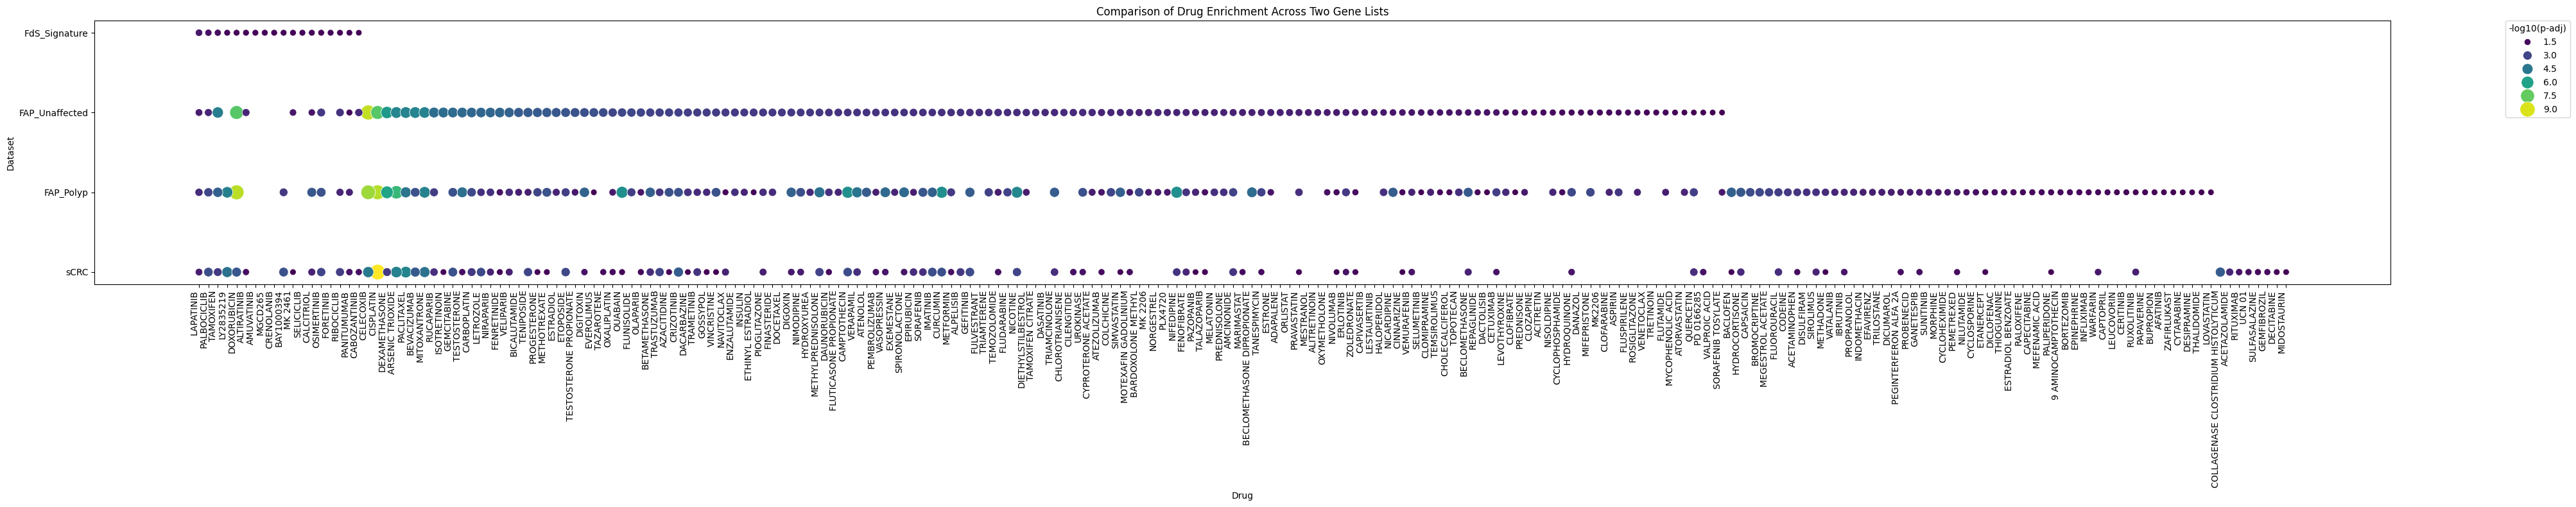

In [ ]:
# # Preprocess your two datasets
# df1_clean = preprocess_enrichr(summary_genes[summary_genes['Gene_set'].isin(drug_gene_sets)], 'Polyps')
# df2_clean = preprocess_enrichr(summary_genes_sporadic[summary_genes_sporadic['Gene_set'].isin(drug_gene_sets)], 'Cancer')

# combined = pd.concat([df1_clean, df2_clean])
# shared_terms = set(df1_clean['Term']) & set(df2_clean['Term'])
# combined = combined[combined['Term'].isin(shared_terms)]

# Pivot for better sorting on x-axis
drug_order = combined.groupby('Term')['-log10_pval'].max().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(40, 8))

# Create the plot
scatter = sns.scatterplot(
    data=combined,
    x='Term',
    y='Dataset',
    size='-log10_pval',
    hue='-log10_pval',
    palette='viridis',
    sizes=(50, 300),
    legend='brief'
)

# Rotate x-axis labels for readability
plt.xticks(rotation=90, ha='right')
plt.xlabel('Drug')
plt.ylabel('Dataset')
plt.title('Comparison of Drug Enrichment Across Two Gene Lists')

# Move legend outside the plot
plt.legend(
    title='-log10(p-adj)',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()
